[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1UaGOtIEAbSN7iMiazqOOLcgcp0kaXW7o#scrollTo=RozLbvuvqG2x)


# **Flower Classifier using Vision Transformers**

⚠️ You must have the `flowers` folder in your directory 🌸📁.


## 00. Introduction to Vision Transformers

**Definition:** Vision Transformers (ViTs) are a type of deep learning architecture that adapts the Transformer architecture (originally designed for NLP) to visual data.

<br>

**ViT Architecure:**

1. *Image Tokenization:* Images are split into fixed-size patches (e.g., 16x16 pixels) flattened, and treated as sequences (like words in NLP).

2. *Positional Encoding:* Each patch is assigned a positjonal encoding to retain spatial information.

3. *Transformer Layers:* Each token (patch interacts with others through the transformer's self-attention mechanism.

4. *Classification Head (MLP Head):* Finally, a classification head or decoder generates predictions or embeddings.

![How ViT works in a nutshell](https://drive.google.com/uc?export=view&id=1tAnIO4NjESLG_hu_1lB8UmTYPQq0RETd)




## 01. Enviroment Setup

🔌Mount your drive to access project files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📂 Now, browse to the working directory

In [ ]:
# Your path to FlowerLover
%cd '/content/drive/MyDrive/FlowerLover/'

/content/drive/MyDrive/FlowerLover


📦 Install and import neccesary libraries

In [ ]:
!pip install timm torch torchvision scikit-learn tqdm &>/dev/null

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

In [ ]:
import timm  # Library for Vision Transformer models

import torch
from torch import optim , nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

from torchvision import datasets , transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Custom Color Palette
custom_palette = [
    "#5b9e4e", "#a8dba8", "#f0b800", "#f8dd6c", "#f6b176",
    "#f88840", "#e93967", "#d41944", "#c4347c", "#fff2d5",
    "#d9d9d9", "#5ec2c1", "#3a96d9","#fde2e4", "#d3f8f2"]

## 02. Data Preparation and Preprocessing


### Loading the Flower Dataset  📂🌼


In [ ]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

### Prepping data for training, validation, and testing 🖼️🔄


The images are normalized using pre-defined mean and standard deviation values that are commonly used for models trained on the ImageNet dataset. The values are:
- Mean: `[0.485, 0.456, 0.406]` for the RGB channels respectively.
- Standard Deviation: `[0.229, 0.224, 0.225]` for the RGB channels respectively.

The normalization formula for each pixel is:
 `normalized_pixel = (pixel_value - mean) / standard_deviation `

In [ ]:
data_transforms = {

    'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    'valid': transforms.Compose([transforms.RandomResizedCrop(256),transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

    'test': transforms.Compose([transforms.RandomResizedCrop(256),transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

image_datasets = {

    'train' : datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms["valid"]),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms["test"])

}

dataloaders = {

    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True ,num_workers=2, pin_memory=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, num_workers=2, pin_memory=True),
    'test': DataLoader(image_datasets['test'], batch_size=32)

}

In [ ]:
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
test_loader = dataloaders['test']

### Mapping labels to their respective classes 🏷️🔢

In [ ]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## 03. Vision Transformers Training


### Function and Class Definitions 🧰📝

In [ ]:
# Model builder for Vision Transformers
def build_transformer_model(model_name='vit_base_patch16_224', hidden_units=512, output_size=102, dropout_rate=0.5):
    # Load the pre-trained Transformer model from timm
    model = timm.create_model(model_name, pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Vision Transformers typically have a head named `head`
    input_size = model.head.in_features
    model.head = nn.Sequential(
        nn.Linear(input_size, hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, output_size),
        nn.LogSoftmax(dim=1)
    )

    return model

In [ ]:
# Training setup
def setup_training(model, learning_rate=0.001, optimizer_type="adam", loss_fn_type="nll_loss"):
    # Select optimizer
    optimizers = {
        "adam": optim.Adam,
        "sgd": optim.SGD,
        "adamw": optim.AdamW
    }

    if optimizer_type not in optimizers:
        raise ValueError(f"Unsupported optimizer! Choose from: {list(optimizers.keys())}")

    optimizer = optimizers[optimizer_type](model.parameters(), lr=learning_rate)

    # Select loss function
    loss_fns = {
        "nll_loss": nn.NLLLoss,
        "cross_entropy": nn.CrossEntropyLoss
    }

    if loss_fn_type not in loss_fns:
        raise ValueError(f"Unsupported loss function! Choose from: {list(loss_fns.keys())}")

    criterion = loss_fns[loss_fn_type]()

    return optimizer, criterion


In [ ]:
# Defining Early Stopping : Training stops when the validation loss doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):

        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Training function
def train_model(model, optimizer, criterion, train_loader, valid_loader, epochs=15, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Scaler for mixed precision
    scaler = GradScaler('cuda')

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    early_stopping = EarlyStopping(patience=patience)

    # Initializing history dictionary
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(epochs):
        model.train()
        train_accuracy = 0
        running_loss = 0.0

        # Training phase
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Clearing old gradients
                with autocast('cuda'):  # Mixed precision
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()

                # Calculate training accuracy for this batch
                top_class = outputs.argmax(dim=1)
                equals = top_class == labels
                train_accuracy += equals.float().mean().item()

                pbar.update(1)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_accuracy = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast('cuda'):  # Mixed precision
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels)
                    valid_loss += batch_loss.item()

                    # Validation accuracy calculation
                    top_class = outputs.argmax(dim=1)
                    equals = top_class == labels
                    valid_accuracy += equals.float().mean().item()

        # Calculate epoch statistics
        train_loss = running_loss / len(train_loader)
        train_acc = train_accuracy / len(train_loader)
        val_loss = valid_loss / len(valid_loader)
        val_acc = valid_accuracy / len(valid_loader)

        # Append epoch statistics to history
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Train accuracy: {train_acc:.3f}.. "
              f"Validation loss: {val_loss:.3f}.. "
              f"Validation accuracy: {val_acc:.3f}")

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return model, history, optimizer


### Training ViT Models 👁️🏋️‍♂️

In [ ]:
transformer_configs = [
    "vit_base_patch16_224",  # Vision Transformer (ViT) Base
    "deit_base_patch16_224",  # DeiT (Data-efficient Image Transformer) Base
    "vit_small_r26_s32_224"  # ConvNext-ViT Hybrid - Combines convolutional inductive biases with Vision Transformer heads.
]

learning_rate = 0.001
optimizer_type = "adam"
loss_function = "nll_loss"
epochs = 10
patience = 5  # Early stopping patience

# Store histories, trained models, and optimizers
all_histories = {}
trained_models = {}
all_optimizers = {}

# Training each transformer model
for model_name in transformer_configs:
    print(f"Training {model_name}:")

    model = build_transformer_model(model_name)
    optimizer, criterion = setup_training(model, learning_rate, optimizer_type, loss_function)
    model, history, optimizer = train_model(model, optimizer, criterion, train_loader, valid_loader, epochs=epochs)

    trained_models[model_name] = model
    all_histories[model_name] = history
    all_optimizers[model_name] = optimizer

    print("-" * 50)


Training vit_base_patch16_224:


Epoch 1/10: 100%|██████████| 205/205 [00:52<00:00,  3.90batch/s]


Epoch 1/10.. Train loss: 0.958.. Train accuracy: 0.791.. Validation loss: 0.237.. Validation accuracy: 0.941


Epoch 2/10: 100%|██████████| 205/205 [00:44<00:00,  4.57batch/s]


Epoch 2/10.. Train loss: 0.231.. Train accuracy: 0.939.. Validation loss: 0.214.. Validation accuracy: 0.949


Epoch 3/10: 100%|██████████| 205/205 [00:44<00:00,  4.66batch/s]


Epoch 3/10.. Train loss: 0.207.. Train accuracy: 0.946.. Validation loss: 0.205.. Validation accuracy: 0.949


Epoch 4/10: 100%|██████████| 205/205 [00:45<00:00,  4.48batch/s]


Epoch 4/10.. Train loss: 0.182.. Train accuracy: 0.954.. Validation loss: 0.193.. Validation accuracy: 0.954


Epoch 5/10: 100%|██████████| 205/205 [00:44<00:00,  4.59batch/s]


Epoch 5/10.. Train loss: 0.179.. Train accuracy: 0.954.. Validation loss: 0.149.. Validation accuracy: 0.963


Epoch 6/10: 100%|██████████| 205/205 [00:45<00:00,  4.47batch/s]


Epoch 6/10.. Train loss: 0.158.. Train accuracy: 0.959.. Validation loss: 0.162.. Validation accuracy: 0.958


Epoch 7/10: 100%|██████████| 205/205 [00:48<00:00,  4.24batch/s]


Epoch 7/10.. Train loss: 0.180.. Train accuracy: 0.951.. Validation loss: 0.236.. Validation accuracy: 0.958


Epoch 8/10: 100%|██████████| 205/205 [00:45<00:00,  4.46batch/s]


Epoch 8/10.. Train loss: 0.143.. Train accuracy: 0.960.. Validation loss: 0.179.. Validation accuracy: 0.960


Epoch 9/10: 100%|██████████| 205/205 [00:54<00:00,  3.73batch/s]


Epoch 9/10.. Train loss: 0.124.. Train accuracy: 0.968.. Validation loss: 0.141.. Validation accuracy: 0.968


Epoch 10/10: 100%|██████████| 205/205 [01:06<00:00,  3.09batch/s]


Epoch 10/10.. Train loss: 0.122.. Train accuracy: 0.966.. Validation loss: 0.132.. Validation accuracy: 0.970
--------------------------------------------------
Training deit_base_patch16_224:


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 205/205 [00:45<00:00,  4.55batch/s]


Epoch 1/10.. Train loss: 2.109.. Train accuracy: 0.515.. Validation loss: 0.876.. Validation accuracy: 0.792


Epoch 2/10: 100%|██████████| 205/205 [00:44<00:00,  4.56batch/s]


Epoch 2/10.. Train loss: 0.774.. Train accuracy: 0.791.. Validation loss: 0.579.. Validation accuracy: 0.858


Epoch 3/10: 100%|██████████| 205/205 [00:46<00:00,  4.45batch/s]


Epoch 3/10.. Train loss: 0.547.. Train accuracy: 0.847.. Validation loss: 0.411.. Validation accuracy: 0.905


Epoch 4/10: 100%|██████████| 205/205 [00:45<00:00,  4.54batch/s]


Epoch 4/10.. Train loss: 0.446.. Train accuracy: 0.873.. Validation loss: 0.357.. Validation accuracy: 0.907


Epoch 5/10: 100%|██████████| 205/205 [00:44<00:00,  4.57batch/s]


Epoch 5/10.. Train loss: 0.397.. Train accuracy: 0.891.. Validation loss: 0.410.. Validation accuracy: 0.884


Epoch 6/10: 100%|██████████| 205/205 [00:44<00:00,  4.59batch/s]


Epoch 6/10.. Train loss: 0.349.. Train accuracy: 0.901.. Validation loss: 0.325.. Validation accuracy: 0.916


Epoch 7/10: 100%|██████████| 205/205 [01:29<00:00,  2.28batch/s]


Epoch 7/10.. Train loss: 0.319.. Train accuracy: 0.911.. Validation loss: 0.327.. Validation accuracy: 0.921


Epoch 8/10: 100%|██████████| 205/205 [01:33<00:00,  2.20batch/s]


Epoch 8/10.. Train loss: 0.308.. Train accuracy: 0.909.. Validation loss: 0.337.. Validation accuracy: 0.908


Epoch 9/10: 100%|██████████| 205/205 [00:57<00:00,  3.59batch/s]


Epoch 9/10.. Train loss: 0.282.. Train accuracy: 0.918.. Validation loss: 0.321.. Validation accuracy: 0.917


Epoch 10/10: 100%|██████████| 205/205 [00:57<00:00,  3.57batch/s]


Epoch 10/10.. Train loss: 0.259.. Train accuracy: 0.929.. Validation loss: 0.257.. Validation accuracy: 0.934
--------------------------------------------------
Training vit_small_r26_s32_224:


model.safetensors:   0%|          | 0.00/146M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 205/205 [00:43<00:00,  4.72batch/s]


Epoch 1/10.. Train loss: 0.678.. Train accuracy: 0.864.. Validation loss: 0.109.. Validation accuracy: 0.974


Epoch 2/10: 100%|██████████| 205/205 [00:40<00:00,  5.10batch/s]


Epoch 2/10.. Train loss: 0.118.. Train accuracy: 0.971.. Validation loss: 0.135.. Validation accuracy: 0.975


Epoch 3/10: 100%|██████████| 205/205 [00:36<00:00,  5.56batch/s]


Epoch 3/10.. Train loss: 0.110.. Train accuracy: 0.973.. Validation loss: 0.113.. Validation accuracy: 0.975


Epoch 4/10: 100%|██████████| 205/205 [00:36<00:00,  5.62batch/s]


Epoch 4/10.. Train loss: 0.095.. Train accuracy: 0.974.. Validation loss: 0.117.. Validation accuracy: 0.974


Epoch 5/10: 100%|██████████| 205/205 [00:41<00:00,  4.94batch/s]


Epoch 5/10.. Train loss: 0.067.. Train accuracy: 0.984.. Validation loss: 0.089.. Validation accuracy: 0.987


Epoch 6/10: 100%|██████████| 205/205 [01:17<00:00,  2.66batch/s]


Epoch 6/10.. Train loss: 0.061.. Train accuracy: 0.985.. Validation loss: 0.088.. Validation accuracy: 0.986


Epoch 7/10: 100%|██████████| 205/205 [01:00<00:00,  3.41batch/s]


Epoch 7/10.. Train loss: 0.062.. Train accuracy: 0.985.. Validation loss: 0.069.. Validation accuracy: 0.988


Epoch 8/10: 100%|██████████| 205/205 [01:11<00:00,  2.85batch/s]


Epoch 8/10.. Train loss: 0.052.. Train accuracy: 0.986.. Validation loss: 0.104.. Validation accuracy: 0.983


Epoch 9/10: 100%|██████████| 205/205 [00:48<00:00,  4.20batch/s]


Epoch 9/10.. Train loss: 0.063.. Train accuracy: 0.984.. Validation loss: 0.094.. Validation accuracy: 0.976


Epoch 10/10: 100%|██████████| 205/205 [01:06<00:00,  3.07batch/s]


Epoch 10/10.. Train loss: 0.056.. Train accuracy: 0.985.. Validation loss: 0.079.. Validation accuracy: 0.986
--------------------------------------------------


### Plotting Models' Training History 📉📈

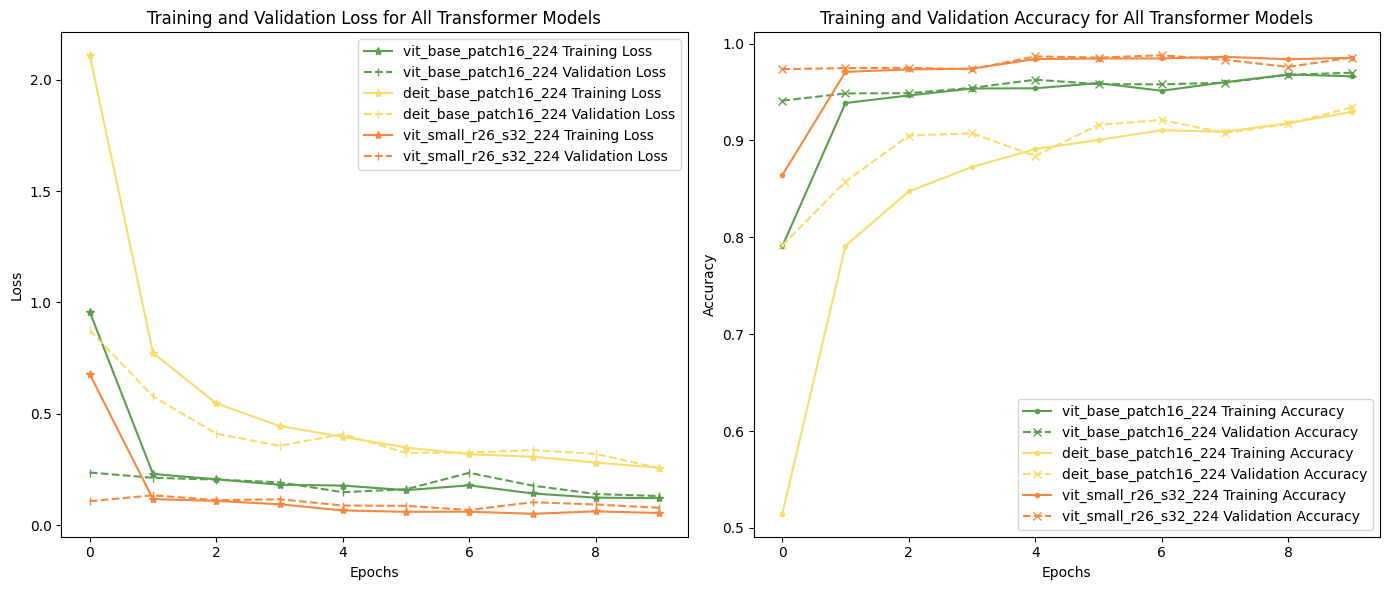

In [ ]:

# Plot the training/validation metrics for transformers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = [custom_palette[i] for i in [0, 3, 5, 8]]

# Plotting Loss in the first subplot
for i, (model_name, history) in enumerate(all_histories.items()):
    ax1.plot(history["train_loss"], label=f"{model_name} Training Loss", color=colors[i], marker='*')
    ax1.plot(history["val_loss"], label=f"{model_name} Validation Loss", linestyle="--", color=colors[i], marker='|')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss for All Transformer Models")
ax1.legend()

# Plotting Accuracy in the second subplot
for i, (model_name, history) in enumerate(all_histories.items()):
    ax2.plot(history["train_accuracy"], label=f"{model_name} Training Accuracy", color=colors[i], marker='.')
    ax2.plot(history["val_accuracy"], label=f"{model_name} Validation Accuracy", linestyle="--", color=colors[i], marker='x')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and Validation Accuracy for All Transformer Models")
ax2.legend()

plt.tight_layout()
plt.show()


## 04. Models Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dictionary to store evaluation metrics
metrics_summary = []

# Evaluate each model
for model_name, model in trained_models.items():
    print(f"Evaluating {model_name}...")

    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Collect predictions and true labels
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=1)

    # Add metrics to the summary list
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

print("-" * 50)

# Convert metrics summary to DataFrame for display
metrics_df = pd.DataFrame(metrics_summary)

# Display the table
print("Evaluation Metrics:")
display(metrics_df)


Evaluating vit_base_patch16_224...
Evaluating deit_base_patch16_224...
Evaluating vit_small_r26_s32_224...
--------------------------------------------------
Evaluation Metrics:


,Model,Accuracy,Precision,Recall,F1 Score
0,vit_base_patch16_224,0.958486,0.962256,0.958486,0.958061
1,deit_base_patch16_224,0.896215,0.909662,0.896215,0.895898
2,vit_small_r26_s32_224,0.976801,0.978917,0.976801,0.976320


## 05. Saving Checkpoints 🗂️💾

In [ ]:
# Directory to save the models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists


metadata = {'learning_rate': learning_rate,'optimizer_type': optimizer_type,'loss_function': loss_function,'earlystopping_patience': patience}

# Save models
for model_name, model in trained_models.items():
    save_path = os.path.join(save_dir, f"{model_name}_checkpoint.pth")

    # Save the model's state and metadata
    checkpoint = {
        'model_name': model_name,
        'model_state_dict': model.state_dict(),
        'class_to_idx': image_datasets['train'].class_to_idx,
        'optimizer_state_dict': all_optimizers[model_name].state_dict(),
        'training_metadata': metadata
        }

    torch.save(checkpoint, save_path)
    print(f"Saved {model_name} to {save_path}")


Saved vit_base_patch16_224 to saved_models\vit_base_patch16_224_checkpoint.pth
Saved deit_base_patch16_224 to saved_models\deit_base_patch16_224_checkpoint.pth
Saved vit_small_r26_s32_224 to saved_models\vit_small_r26_s32_224_checkpoint.pth


## 06. Inference for Classification


### Loading Model Checkpoints 🗃️🔄


In [ ]:
def load_model(checkpoint_path):

    # Map the checkpoint to the appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Build the model (without redefining the classifier)
    model = build_transformer_model(model_name=checkpoint['model_name'])

    # Load the model weights
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    model.class_to_idx = checkpoint['class_to_idx']

    return model


In [ ]:
vit_base_patch16_224 = load_model('saved_models/vit_base_patch16_224_checkpoint.pth')
deit_base_patch16_224 = load_model('saved_models/deit_base_patch16_224_checkpoint.pth')
vit_small_r26_s32_224 = load_model('saved_models/vit_small_r26_s32_224_checkpoint.pth')

models = {'vit base patch16 224':vit_base_patch16_224 , 'deit base patch16 224': deit_base_patch16_224 , 'vit small r26 s32 224':vit_small_r26_s32_224 }

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/146M [00:00<?, ?B/s]

### Processing Input Image 🖼️

In [ ]:
def process_image(image):

    image = Image.open(image)  # Open image if a path is provided

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return preprocess(image)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):

    if ax is None:
        _ , ax = plt.subplots()

    # PyTorch tensors expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Thus, reordering dimensions using transpose
    image = image.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)

    if normalize:
        # Reverse normalization (undo preprocessing)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Clip the image values to the range [0, 1] to prevent display artifacts or noise

    ax.imshow(image)
    ax.axis('off')
    if title:
        ax.set_title(title)

    return ax


### Top-K Prediction 🥇

In [ ]:
# Predicting top-K most probable classes

def predict(image_path, model,top_k=5):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    tensor_image = process_image(image_path)
    tensor_image = tensor_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor_image)

    probabilities = torch.softmax(output, dim=1)
    top_probs, top_indices = probabilities.topk(top_k)

    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, classes

### Sanity check across multiple models for comparison 🧠🧪

In [ ]:
def sanity_checking(image_path, models, top_k=5):

    # Extract real species name from image path
    label = image_path.split('/')[-2]  # Extract the label from the path
    real_species_name = cat_to_name.get(label, "Unknown Species")  # Map to species name

    num_models = len(models)

    # Create subplots dynamicly : one for the image and one for each model
    _, axes = plt.subplots(1, num_models + 1, figsize=(5 * (num_models + 1), 5))

    img = process_image(image_path)

    # Displaying the processed inputted image
    imshow(img, ax=axes[0], title=f"Flower Type: {real_species_name}")

    # Looping through models
    for idx, (model_name, model) in enumerate(models.items(), start=1):

        probs, classes = predict(image_path, model, top_k)
        class_names = [cat_to_name.get(str(cls)) for cls in classes]

        y_pos = np.arange(len(class_names))
        axes[idx].barh(y_pos, probs, align='center', color=custom_palette[:top_k])
        axes[idx].set_yticks(y_pos)
        axes[idx].set_yticklabels(class_names)
        axes[idx].invert_yaxis()  # Highest probability at the top
        axes[idx].set_xlabel('Probability')
        axes[idx].set_title(f"Model: {model_name}")

    plt.tight_layout()
    plt.show()


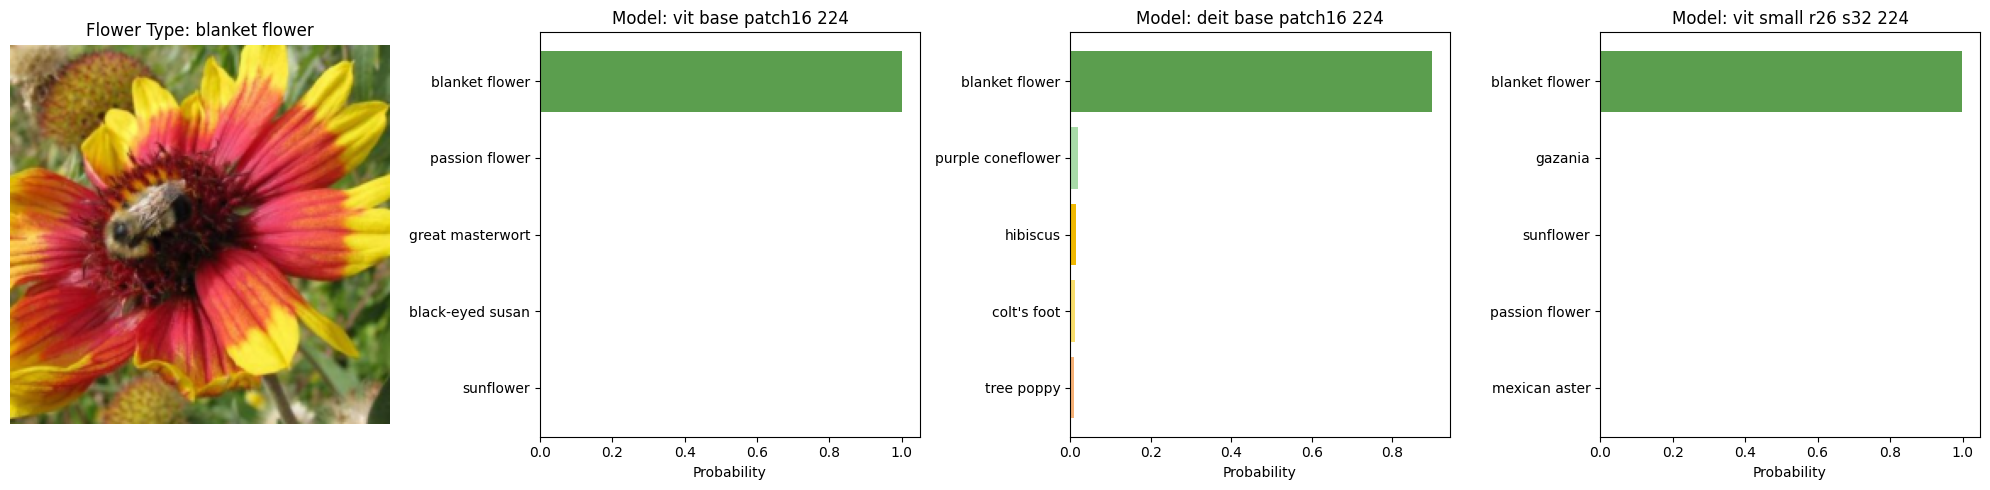

In [ ]:
sanity_checking('flowers/test/100/image_07896.jpg', models)

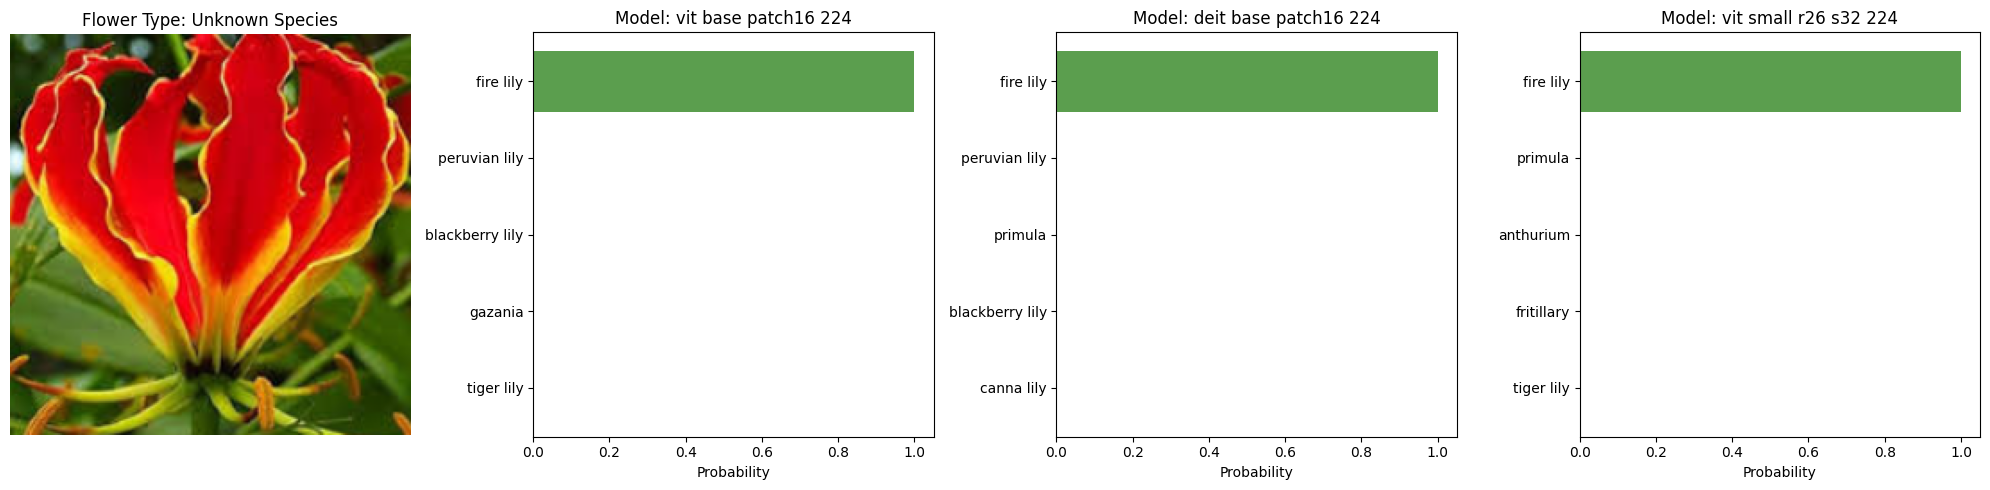

In [ ]:
sanity_checking('assets/download.jpg', models)

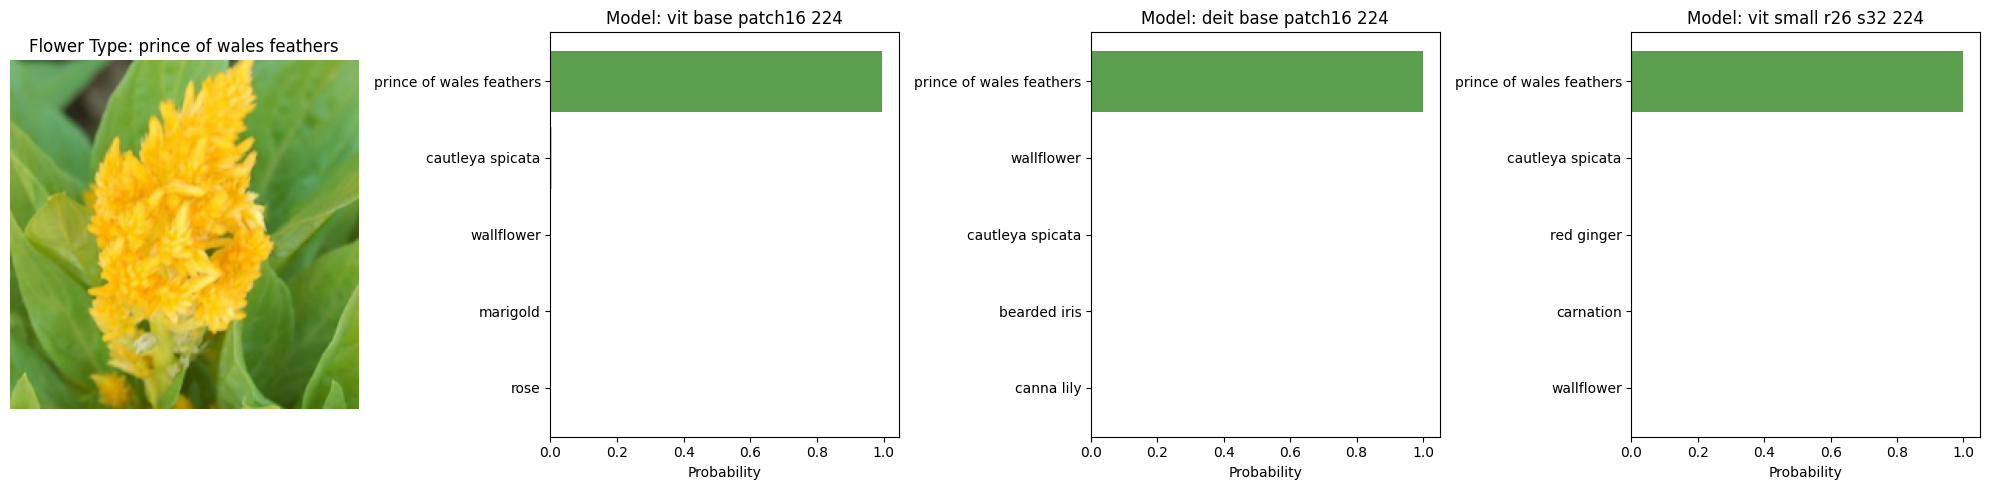

In [ ]:
sanity_checking('flowers/test/27/image_06864.jpg', models)

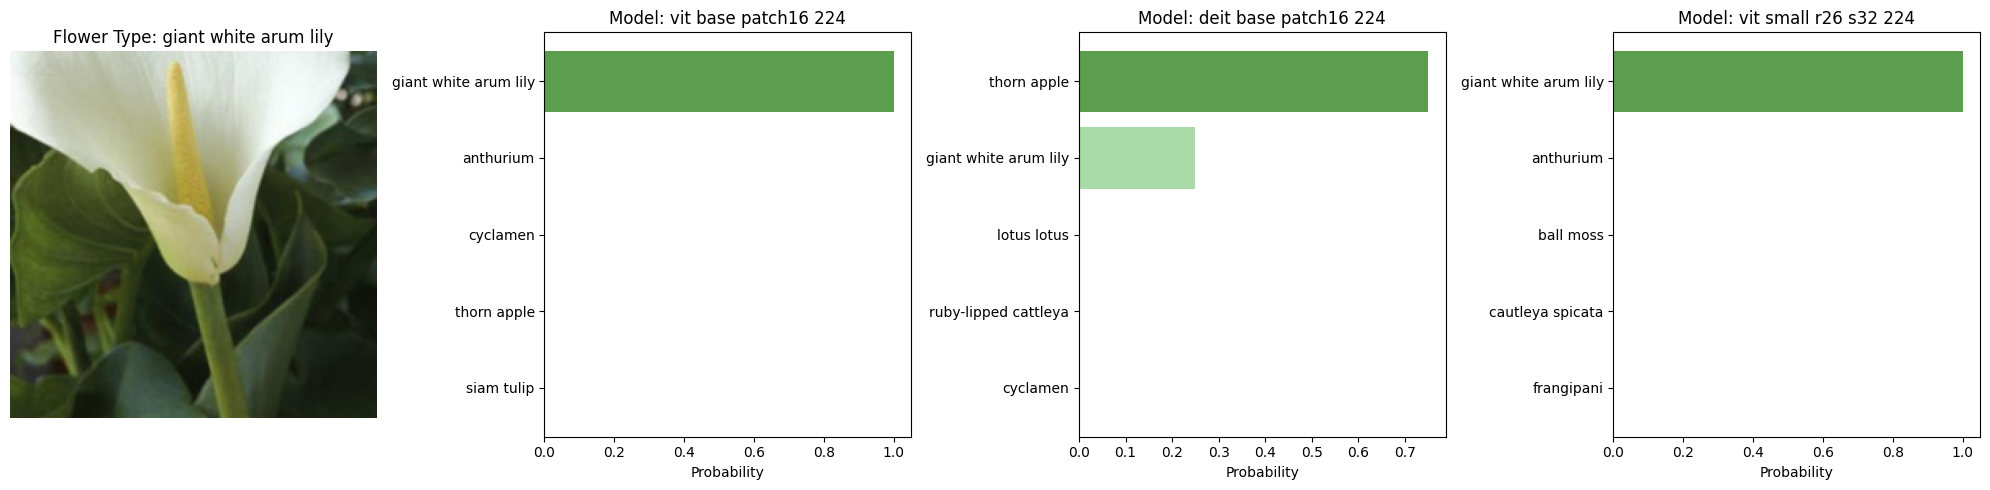

In [ ]:
sanity_checking('flowers/test/20/image_04910.jpg', models)

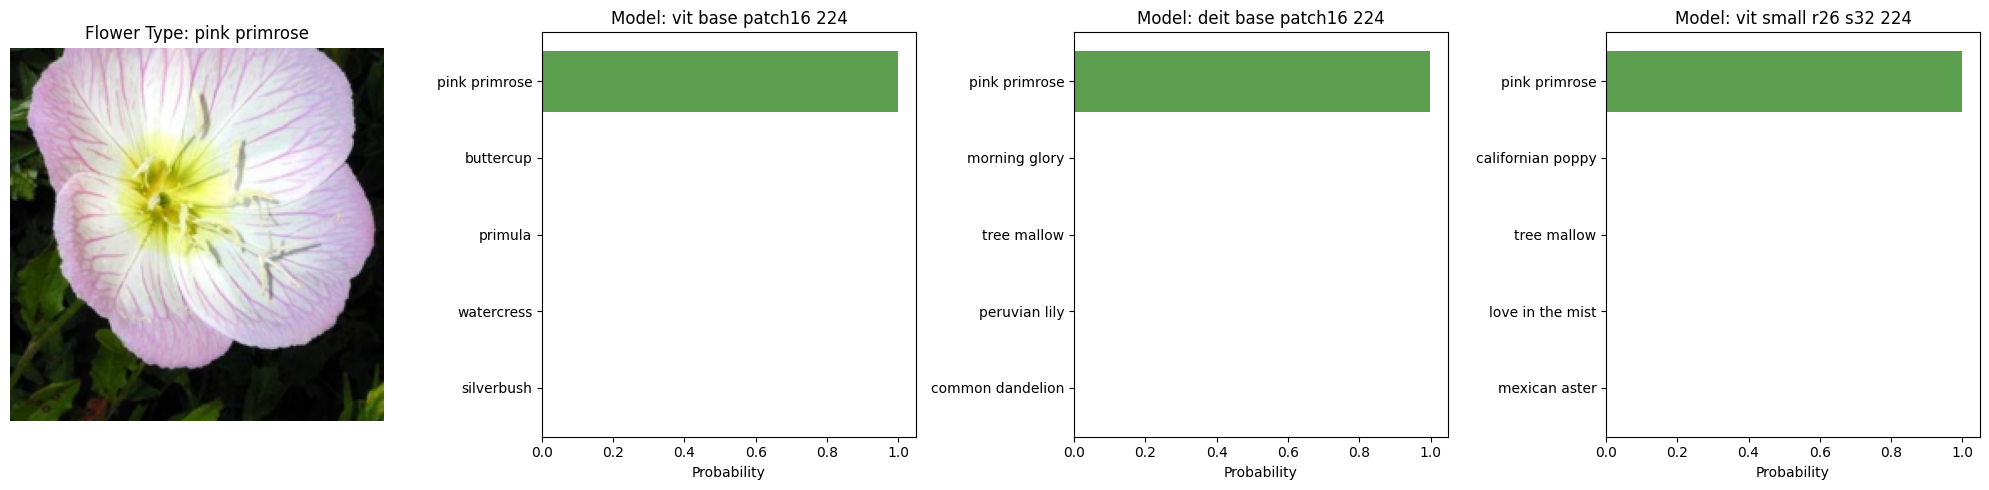

In [ ]:
sanity_checking('flowers/test/1/image_06743.jpg', models)

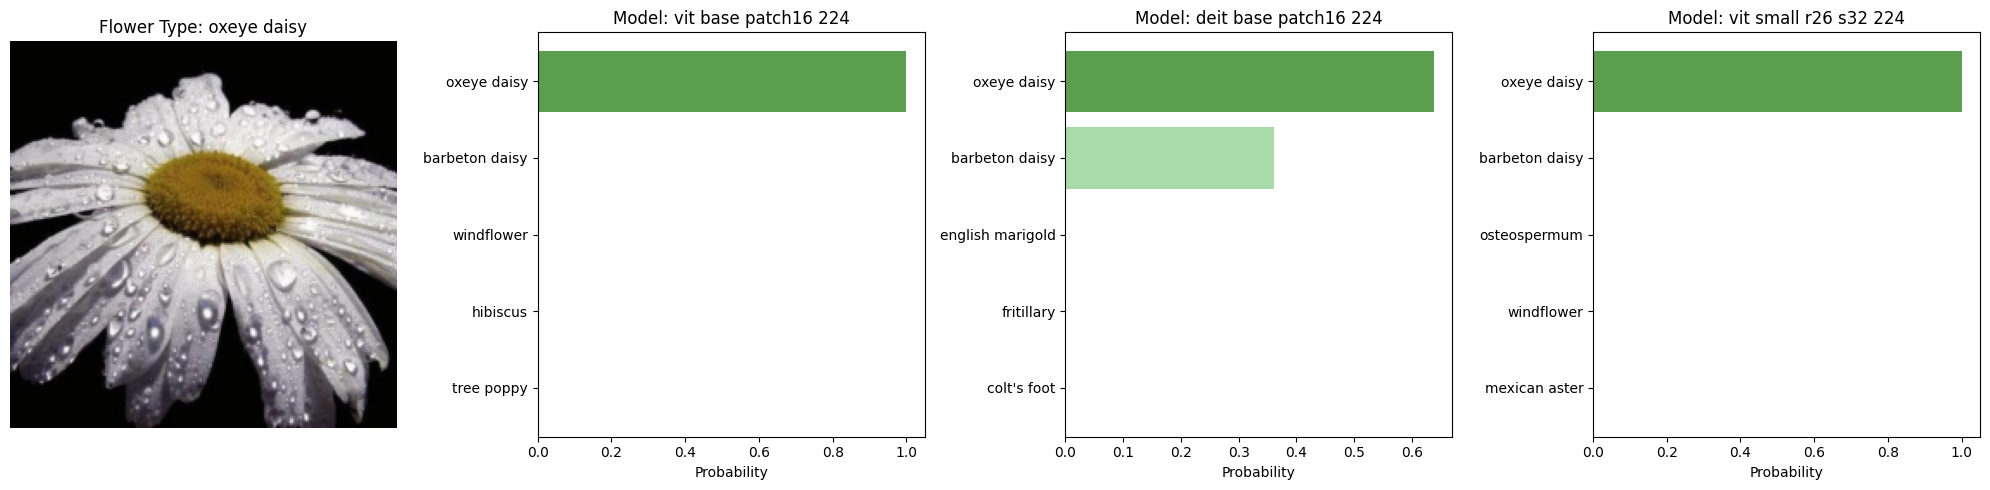

In [ ]:
sanity_checking('flowers/test/49/image_06202.jpg', models)

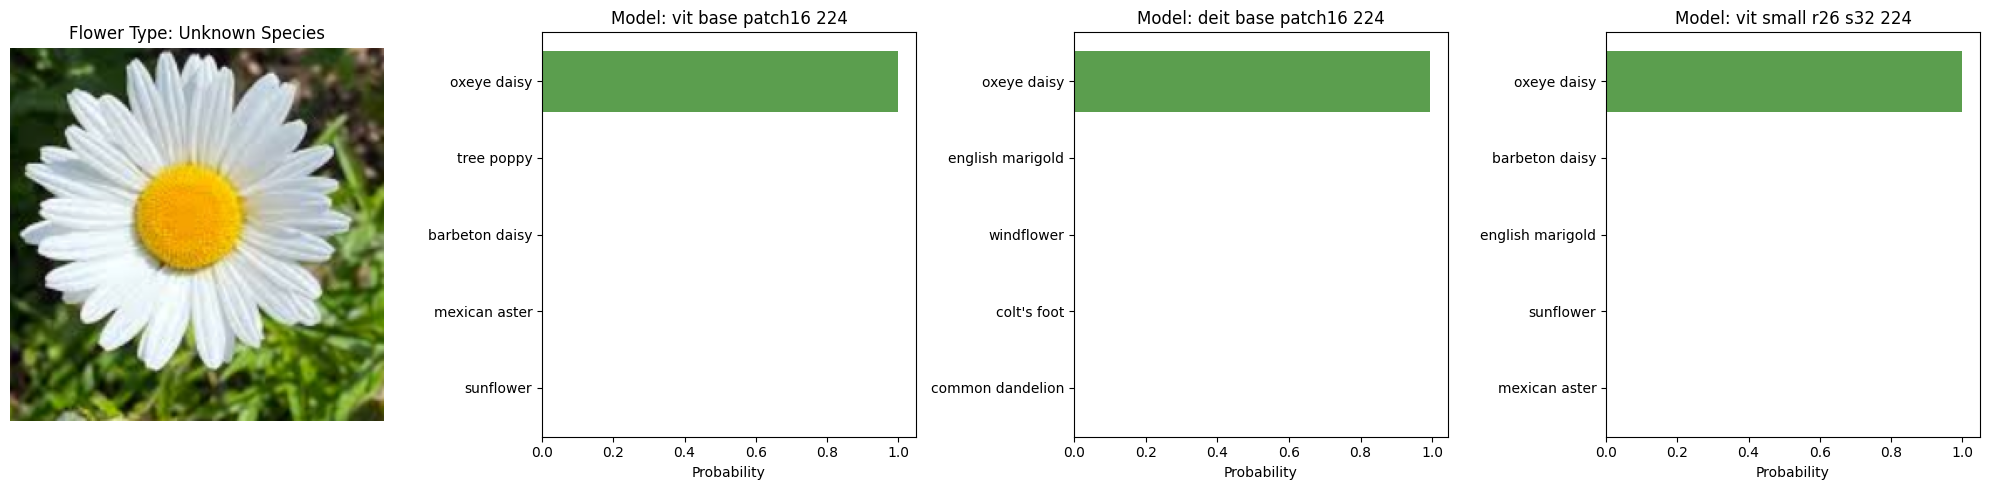

In [ ]:
sanity_checking('assets/download1.jpg', models)

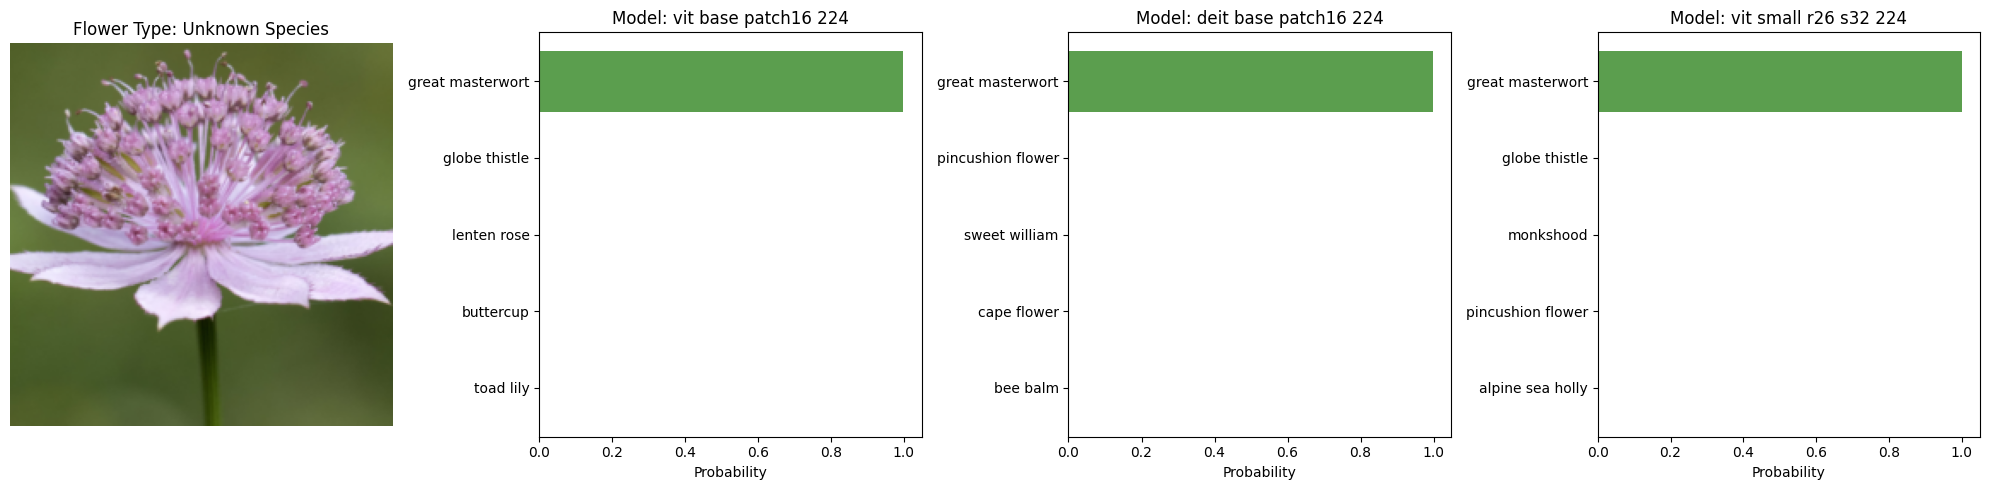

In [ ]:
sanity_checking('assets/download2.jpg', models)

## 07. ViTs vs. CNNs: Performance Insights

ViTs exhibit outstanding performance in accurately identifying flower species, as evident from the visualized predictions. Their strength lies in capturing global relationships within an image, enabling them to outperform traditional CNNs in complex classification tasks.<br>

However, CNNs remain strong contenders due to their computational efficiency and ability to model local spatial structures effectively.

<br>

🌟 **Want to test it yourself?** <br>

You can experiment with the performance of ViTs and CNNs using the `Flower Classifier - Test Your Own Images` notebook.<br>

Alternatively, download the `Flower Classifier Streamlit.zip`, unzip it and follow the instructions in the `Follow These Steps.txt` file to try it out on your own images.

